In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../DropEdge/src'))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import time
import argparse
import numpy as np
import json

import torch
import torch.nn.functional as F
import torch.optim as optim
#from tensorboardX import SummaryWriter

from earlystopping import EarlyStopping
from sample import Sampler
from metric import accuracy, roc_auc_compute_fn
# from deepgcn.utils import load_data, accuracy
# from deepgcn.models import GCN

from metric import accuracy
from utils import load_citation, load_reddit_data
from models import *
from earlystopping import EarlyStopping
from sample import Sampler

In [6]:
nbaseblocklayer = 2

with open('../DropEdge/models/cora_gcn_{0}blocks.json'.format(nbaseblocklayer), 'r') as f:
    args = json.load(f)

sampler = Sampler(args['dataset'], '../DropEdge/data/', args['task_type'])
labels, idx_train, idx_val, idx_test = sampler.get_label_and_idxes(args['cuda'])
nfeat = sampler.nfeat
nclass = sampler.nclass

device = 'cuda'
base_model = GCNModel(nfeat=nfeat,
                      nhid=args['hidden'],
                      nclass=nclass,
                      nhidlayer=args['nhiddenlayer'],
                      dropout=args['dropout'],
                      baseblock=args['type'],
                      inputlayer=args['inputlayer'],
                      outputlayer=args['outputlayer'],
                      nbaselayer=args['nbaseblocklayer'],
                      activation=F.relu,
                      withbn=args['withbn'],
                      withloop=args['withloop'],
                      aggrmethod=args['aggrmethod'],
                      mixmode=args['mixmode']
                     )
base_model.load_state_dict(torch.load(
    '../DropEdge/models/cora_gcn_{0}blocks.pt'.format(nbaseblocklayer)))
base_model.eval()
base_model.to(device)

Load full supervised task.


GCNModel(
  (ingc): GraphConvolutionBS()
  (outgc): GraphConvolutionBS()
  (midlayer): ModuleList(
    (0): MultiLayerGCNBlock(
      (model): GraphBaseBlock(
        (hiddenlayers): ModuleList(
          (0): GraphConvolutionBS()
          (1): GraphConvolutionBS()
        )
      )
    )
  )
)

In [6]:
from torch.nn import Module


class GraphConvolutionBSSVD(Module):
    def __init__(self, orig_layer, r=None):
        super(GraphConvolutionBSSVD, self).__init__()
        
        if r == None:
            r = min(orig_layer.in_features, orig_layer.out_features)
            
        self.r = r
        
        self.in_features = orig_layer.in_features
        self.out_features = orig_layer.out_features
        self.sigma = orig_layer.sigma
        
        U, s, V = torch.svd(orig_layer.weight)
        
        self.U = nn.Parameter(U)
        self.s = nn.Parameter(s)
        self.Vt = nn.Parameter(V.T)
        
        if orig_layer.bias is not None:
            self.bias = Parameter(orig_layer.bias)
        else:
            self.register_parameter('bias', None)


    def forward(self, input, adj):
        support = torch.mm(input, self.U[:, :self.r])
        support = support * self.s[:self.r]
        support = torch.mm(support, self.Vt[:self.r, :])
        output = torch.spmm(adj, support)
        
        if self.bias is not None:
            output = output + self.bias
        
        return self.sigma(output)

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) \
               + ', ' + str(self.r) + ')'
    
    def set_rank(self, r=None):
        if r is None:
            self.r = self.get_max_rank()
        else:
            self.r = r
        
    def get_max_rank(self):
        return len(self.s)

In [7]:
import copy

def make_new_model(model):
    n_layers = len(model.midlayer[0].model.hiddenlayers)
    new_model = copy.deepcopy(model)
    
    new_model.ingc = GraphConvolutionBSSVD(base_model.ingc)
    for i in range(n_layers):
        new_model.midlayer[0].model.hiddenlayers[i] = \
            GraphConvolutionBSSVD(base_model.midlayer[0].model.hiddenlayers[i])
    new_model.outgc = GraphConvolutionBSSVD(base_model.outgc)
    new_model.to(device)
    return new_model

def reset_rank(model):
    model.ingc.set_rank()
    for idx_layer in range(args['nbaseblocklayer']):
        model.midlayer[0].model.hiddenlayers[idx_layer].set_rank()

In [8]:
(train_adj, train_fea) = sampler.randomedge_sampler(
    percent=args['sampling_percent'],
    normalization=args['normalization'],
    cuda=args['cuda']
)

In [9]:
new_model = make_new_model(base_model)
new_model.to(device)

GCNModel(
  (ingc): GraphConvolutionBSSVD (1433 -> 128, 128)
  (outgc): GraphConvolutionBSSVD (128 -> 7, 7)
  (midlayer): ModuleList(
    (0): MultiLayerGCNBlock(
      (model): GraphBaseBlock(
        (hiddenlayers): ModuleList(
          (0): GraphConvolutionBSSVD (128 -> 128, 128)
          (1): GraphConvolutionBSSVD (128 -> 128, 128)
        )
      )
    )
  )
)

In [10]:
torch.abs(new_model(train_fea, train_adj) - base_model(train_fea, train_adj)).max()

tensor(0.0001, device='cuda:0', grad_fn=<MaxBackward1>)

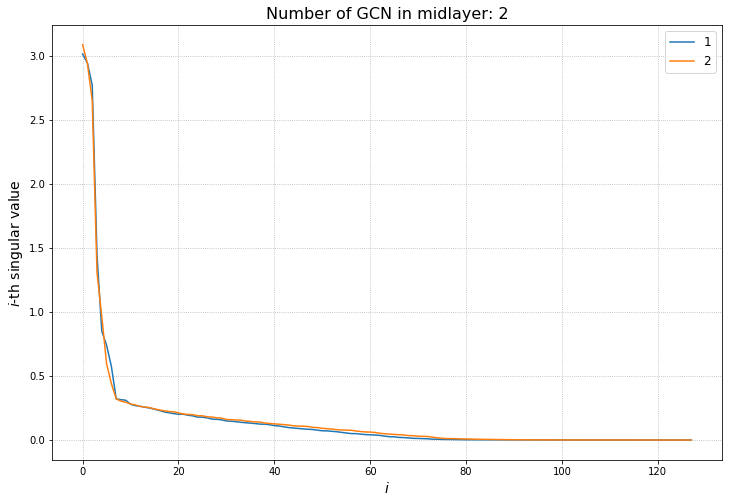

In [30]:
plt.figure(figsize=(12, 8))

plt.title('Number of GCN in midlayer: {}'.format(args['nbaseblocklayer']), fontsize=16)
for i in range(args['nbaseblocklayer']):
    singular_values = new_model.midlayer[0].model.hiddenlayers[i].s.cpu().detach().numpy()
    plt.plot(singular_values, label=str(i + 1))
plt.xlabel('$i$', fontsize=14)
plt.ylabel('$i$-th singular value', fontsize=14)
plt.grid(ls=":")
plt.legend(fontsize=12)
plt.show()

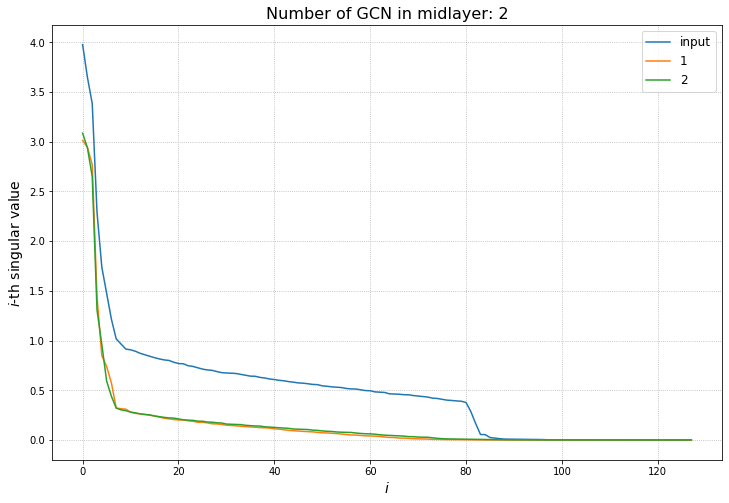

In [11]:
plt.figure(figsize=(12, 8))

plt.title('Number of GCN in midlayer: {}'.format(args['nbaseblocklayer']), fontsize=16)

singular_values = new_model.ingc.s.cpu().detach().numpy()
plt.plot(singular_values, label='input')

for i in range(args['nbaseblocklayer']):
    singular_values = new_model.midlayer[0].model.hiddenlayers[i].s.cpu().detach().numpy()
    plt.plot(singular_values, label=str(i + 1))

plt.xlabel('$i$', fontsize=14)
plt.ylabel('$i$-th singular value', fontsize=14)
plt.grid(ls=":")
plt.legend(fontsize=12)
plt.show()

In [12]:
def test_model(model, test_adj, test_fea):
    model.eval()
    output = model(test_fea, test_adj)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    return loss_test.item(), acc_test.item()

(test_adj, test_fea) = sampler.get_test_set(
    normalization=args['normalization'],
    cuda=args['cuda']
)

In [13]:
from collections import defaultdict


losses = defaultdict(list)
accs = defaultdict(list)

for r in range(1, new_model.ingc.get_max_rank() + 1):
    new_model.ingc.set_rank(r)
    loss, acc = test_model(new_model, test_adj, test_fea)
    losses['input'].append(loss)
    accs['input'].append(acc)
new_model.ingc.set_rank()

In [14]:
for idx_layer in range(args['nbaseblocklayer']):
    for r in range(1, new_model.midlayer[0].model.hiddenlayers[idx_layer].get_max_rank() + 1):
        new_model.midlayer[0].model.hiddenlayers[idx_layer].set_rank(r)
        loss, acc = test_model(new_model, test_adj, test_fea)
        losses[str(idx_layer)].append(loss)
        accs[str(idx_layer)].append(acc)
    new_model.midlayer[0].model.hiddenlayers[idx_layer].set_rank()

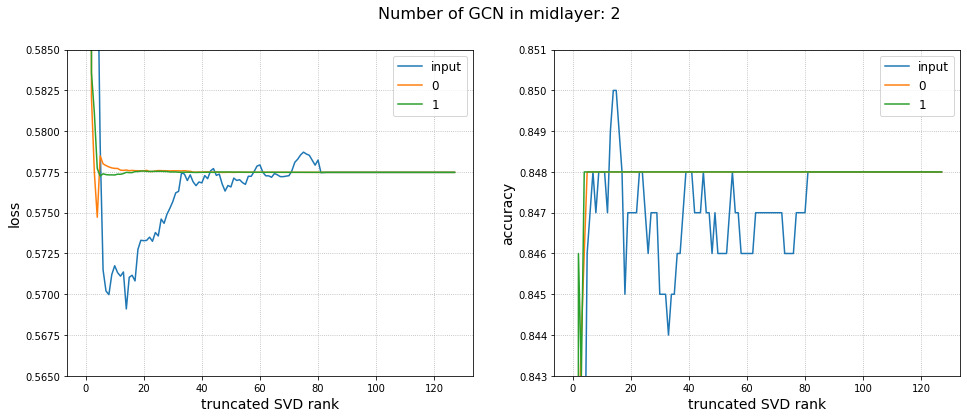

In [15]:
losses_ylim_params = {
    1: (0.45, 0.454),
    2: (0.565, 0.585),
    3: (0.647, 0.660),
    4: (0.7575, 0.761),
    5: (0.76, 0.775),
    6: (None, None),
    7: (1.08, 1.15),
    8: (None, None),
    9: (None, None),
    # 3: (None, None),
}
accs_ylim_params = {
    1: (0.8625, 0.87),
    2: (0.843, 0.851),
    3: (0.83, 0.8475),
    4: (0.78, 0.805),
    5: (0.75, 0.773),
    6: (0.35, 0.42),
    7: (0.608, 0.616),
    8: (0.6, 0.66),
    9: (None, None),
    # 3: (None, None),
}

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
for k in losses:
    plt.plot(losses[k], label=k)
plt.xlabel('truncated SVD rank', fontsize=14)
plt.ylabel('loss', fontsize=14)
plt.grid(ls=":")
plt.legend(fontsize=12)
plt.ylim(*losses_ylim_params[args['nbaseblocklayer']])

plt.subplot(1, 2, 2)
for k in accs:
    plt.plot(accs[k], label=k)
plt.xlabel('truncated SVD rank', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.grid(ls=":")
plt.legend(fontsize=12)
plt.ylim(*accs_ylim_params[args['nbaseblocklayer']])

plt.suptitle('Number of GCN in midlayer: {}'.format(args['nbaseblocklayer']), fontsize=16)

plt.show()

In [16]:
reset_rank(new_model)
# best_input_rank = np.argmax(accs['input']) + 1
# new_model.ingc.set_rank(best_input_rank)

for idx_layer in range(args['nbaseblocklayer']):
    losses_layer = []
    accs_layer = []
    for r in range(1, new_model.midlayer[0].model.hiddenlayers[idx_layer].get_max_rank() + 1):
        new_model.midlayer[0].model.hiddenlayers[idx_layer].set_rank(r)
        loss, acc = test_model(new_model, test_adj, test_fea)
        losses_layer.append(loss)
        accs_layer.append(acc)
    
    r = np.argmax(accs_layer) + 1
    print(r)
    new_model.midlayer[0].model.hiddenlayers[idx_layer].set_rank(r)

6
7
